In [1]:
import pandas as pd
from tensorflow.keras.preprocessing import image

import os 

import tensorflow as tf

from tensorflow.keras.applications.inception_v3 import InceptionV3
from tensorflow.keras.applications.vgg16 import VGG16
from tensorflow.keras.applications.resnet_v2 import ResNet152V2

import matplotlib.pyplot as plt

from tensorflow.keras import layers
from tensorflow.keras import models
from tqdm import tqdm
import numpy as np

In [2]:
df = pd.read_csv('./data/HAM10000_Metadata')

In [ ]:
from tensorflow.keras import backend as K
K.clear_session()

In [3]:
print("Num GPUs Available: ", len(tf.config.list_physical_devices('GPU')))

Num GPUs Available:  1


(Warning for Sunlight, increased risk of cancer) Actinic keratoses and intraepithelial carcinoma / Bowen's disease (__akiec__), 0

(Skin cancer) basal cell carcinoma (__bcc__), 1

(HARMLESS) benign keratosis-like lesions (solar lentigines / seborrheic keratoses and lichen-planus like keratoses, __bkl__), 2

(HARMLESS) dermatofibroma (__df__),  3

melanoma (__mel__),  4

(Not entirely harmless) melanocytic nevi (__nv__)   5

(HARMLESS) vascular lesions (angiomas, angiokeratomas, pyogenic granulomas and hemorrhage, __vasc__). 6 


More than 50% of lesions are confirmed through histopathology (histo), the ground truth for the rest of the cases is either follow-up examination (follow_up), expert consensus (consensus), or confirmation by in-vivo confocal microscopy (confocal). The dataset includes lesions with multiple images, which can be tracked by the lesion_id-column within the HAM10000_metadata file.

In [ ]:
# Number of cases where we can use LSTM

(df['lesion_id'].value_counts() > 1).sum()

In [ ]:
df.head()

In [ ]:
df = df.sample(frac = 1).reset_index()

df.head()

In [ ]:
df['localization'].unique()

In [ ]:
temp = []

for i in range(0, 10015):
    loc = df.iloc[i]['localization']
    if loc == 'abdomen':
        temp.append(tf.one_hot(0, 15))
    elif loc == 'scalp':
        temp.append(tf.one_hot(1, 15))
    elif loc == 'lower extremity':
        temp.append(tf.one_hot(2, 15))
    elif loc == 'trunk':
        temp.append(tf.one_hot(3, 15))
    elif loc == 'upper extremity':
        temp.append(tf.one_hot(4, 15))
    elif loc == 'back':
        temp.append(tf.one_hot(5, 15))
    elif loc == 'neck':
        temp.append(tf.one_hot(6, 15))
    elif loc == 'face':
        temp.append(tf.one_hot(7, 15))
    elif loc == 'chest':
        temp.append(tf.one_hot(8, 15))
    elif loc == 'foot':
        temp.append(tf.one_hot(9, 15))
    elif loc == 'ear':
        temp.append(tf.one_hot(10, 15))
    elif loc == 'unknown':
        temp.append(tf.one_hot(11, 15))
    elif loc == 'hand':
        temp.append(tf.one_hot(12, 15))
    elif loc == 'acral':
        temp.append(tf.one_hot(13, 15))
    elif loc == 'genital':
        temp.append(tf.one_hot(14, 15))

In [ ]:
one_hot_loc = np.array(temp)

one_hot_loc

In [3]:
# VGG-16
preprocessed = []

VGG_load = VGG16(weights='imagenet', include_top=False)
model = models.Sequential()
model.add(VGG_load)
model.add(layers.Flatten())


for i in tqdm(range(0, 10015)):
    file = df.iloc[i]['image_id']
    #ohl = one_hot_loc[i]
    
    img = image.load_img('./Data/HAM10000_images/' + file + '.jpg', target_size= (224,224))
    img = image.img_to_array(img)
    img = np.expand_dims(img, axis=0)
    img = tf.keras.applications.vgg16.preprocess_input(img)
    preds = model.predict(img).reshape(25088)

    preprocessed.append(preds) #np.concatenate((preds, ohl)))
    
df['VGG16'] = preprocessed

100%|████████████████████████████████████████████████████████████████████████████| 10015/10015 [05:01<00:00, 33.19it/s]


In [ ]:
# Inception
preprocessed = []

IV3_load = InceptionV3(weights='imagenet', include_top=False)
model = models.Sequential()
model.add(IV3_load)
model.add(layers.Flatten())

for i in tqdm(range(0, 10015)):
    file = df.iloc[i]['image_id']
    ohl = one_hot_loc[i]
    
    img = image.load_img('./Data/HAM10000_images/' + file + '.jpg', target_size= (299,299))
    img = image.img_to_array(img)
    img = np.expand_dims(img, axis=0)
    img = tf.keras.applications.inception_v3.preprocess_input(img)
    preds = model.predict(img).reshape(131072)

    preprocessed.append(np.concatenate((preds, ohl)))
    
df['IV3'] = preprocessed

In [ ]:
# ResNet
preprocessed = []

resnet_load = ResNet152V2(weights='imagenet', include_top=False)
model = models.Sequential()
model.add(resnet_load)
model.add(layers.Flatten())


for i in tqdm(range(0, 10015)):
    file = df.iloc[i]['image_id']
    ohl = one_hot_loc[i]    
    
    img = image.load_img('./Data/HAM10000_images/' + file + '.jpg', target_size= (224,224))
    img = image.img_to_array(img)
    img = np.expand_dims(img, axis=0)
    img = tf.keras.applications.resnet_v2.preprocess_input(img)
    preds = model.predict(img).reshape(100352)

    preprocessed.append(np.concatenate((preds, ohl)))
    
df['resnet'] = preprocessed

In [26]:
labels = []
for i in range(0, 10015):
    dx = df.iloc[i]['dx']
    if dx == 'akiec':
        labels.append(tf.one_hot(0, 7))
    elif dx == 'bcc':
        labels.append(tf.one_hot(1, 7))
    elif dx == 'bkl':
        labels.append(tf.one_hot(2, 7))
    elif dx == 'df':
        labels.append(tf.one_hot(3, 7))
    elif dx == 'mel':
        labels.append(tf.one_hot(4, 7))
    elif dx == 'nv':
        labels.append(tf.one_hot(5, 7))
    elif dx == 'vasc':
        labels.append(tf.one_hot(6, 7))
        
df['one_hot'] = labels

In [ ]:
df.head()

(Warning for Sunlight, increased risk of cancer) Actinic keratoses and intraepithelial carcinoma / Bowen's disease (__akiec__), 0

(Skin cancer) basal cell carcinoma (__bcc__), 1

(HARMLESS) benign keratosis-like lesions (solar lentigines / seborrheic keratoses and lichen-planus like keratoses, __bkl__), 2

(HARMLESS) dermatofibroma (__df__),  3

melanoma (__mel__),  4

(Not entirely harmless) melanocytic nevi (__nv__)   5

(HARMLESS) vascular lesions (angiomas, angiokeratomas, pyogenic granulomas and hemorrhage, __vasc__). 6 


More than 50% of lesions are confirmed through histopathology (histo), the ground truth for the rest of the cases is either follow-up examination (follow_up), expert consensus (consensus), or confirmation by in-vivo confocal microscopy (confocal). The dataset includes lesions with multiple images, which can be tracked by the lesion_id-column within the HAM10000_metadata file.

In [27]:
risk = []

for i in range(0, 10015):
    if df.iloc[i]['dx'] in ['bkl', 'df', 'vasc']:
        risk.append(0.0)
    elif df.iloc[i]['dx'] == 'nv':
        risk.append(1.0)
    elif df.iloc[i]['dx'] == 'akiec':
        risk.append(2.0)
    elif df.iloc[i]['dx'] in ['mel', 'bcc']:
        risk.append(3.0)
        
df['risk'] = risk

df.head()

,lesion_id,image_id,dx,dx_type,age,sex,localization,dataset,VGG16,one_hot,risk
0,HAM_0000118,ISIC_0027419,bkl,histo,80.0,male,scalp,vidir_modern,"[0.0, 0.0, 11.025183, 0.0, 0.08699386, 0.0, 0....","(tf.Tensor(0.0, shape=(), dtype=float32), tf.T...",0.0
1,HAM_0000118,ISIC_0025030,bkl,histo,80.0,male,scalp,vidir_modern,"[0.0, 0.0, 1.2556057, 0.72405547, 0.0, 0.0, 0....","(tf.Tensor(0.0, shape=(), dtype=float32), tf.T...",0.0
2,HAM_0002730,ISIC_0026769,bkl,histo,80.0,male,scalp,vidir_modern,"[0.0, 0.0, 6.389563, 0.0, 0.0, 0.0, 0.0, 0.0, ...","(tf.Tensor(0.0, shape=(), dtype=float32), tf.T...",0.0
3,HAM_0002730,ISIC_0025661,bkl,histo,80.0,male,scalp,vidir_modern,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","(tf.Tensor(0.0, shape=(), dtype=float32), tf.T...",0.0
4,HAM_0001466,ISIC_0031633,bkl,histo,75.0,male,ear,vidir_modern,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","(tf.Tensor(0.0, shape=(), dtype=float32), tf.T...",0.0


In [ ]:
df[df['risk'] == 3.0]['dx'].value_counts()

In [29]:
df["dx"].value_counts()

nv       6705
mel      1113
bkl      1099
bcc       514
akiec     327
vasc      142
df        115
Name: dx, dtype: int64

In [30]:
df["risk"].value_counts()

1.0    6705
3.0    1627
0.0    1356
2.0     327
Name: risk, dtype: int64

In [5]:
import pickle

In [ ]:
pickle_out = open("VGG16.pickle", "wb")
pickle.dump(df["VGG16"], pickle_out)
pickle_out.close()

pickle_out = open("IV3.pickle", "wb")
pickle.dump(df["IV3"], pickle_out)
pickle_out.close()

pickle_out = open("resnet.pickle", "wb")
pickle.dump(df["resnet"], pickle_out)
pickle_out.close()

In [ ]:
pickle_out = open("one_hot.pickle", "wb")
pickle.dump(df["one_hot"], pickle_out)
pickle_out.close()

pickle_out = open("risk.pickle", "wb")
pickle.dump(df["risk"], pickle_out)
pickle_out.close()

In [6]:
pickle_in = open("VGG16.pickle", "rb")
z_vgg = pickle.load(pickle_in)

pickle_in = open("IV3.pickle", "rb")
z_iv3 = pickle.load(pickle_in)

pickle_in = open("resnet.pickle", "rb")
z_res = pickle.load(pickle_in)

In [7]:
pickle_in = open("one_hot.pickle", "rb")
z_one_hot = pickle.load(pickle_in)

pickle_in = open("risk.pickle", "rb")
z_risk = pickle.load(pickle_in)

In [ ]:
vg_z = np.array(z_vgg)
iv_z = np.array(z_iv3)
res_z = np.array(z_res)
one_hot_z = np.array(z_one_hot)
risk_z = np.array(z_risk)

In [ ]:
df["one_hot"]

In [18]:
VGG_X.shape

(10015,)

In [8]:
VGG_X = np.array(df["VGG16"])
IV3_X = np.array(z_iv3)
RES_X = np.array(z_res)

In [9]:
#y = np.array(df['one_hot'])

y = np.array(z_risk)

array([3., 1., 1., ..., 1., 1., 1.])

In [13]:
new_y = []
for ele in y:
    new_y.append(tf.one_hot(int(ele), 4))
    
new_y = np.array(new_y)

new_y.shape

(10015, 4)

In [14]:
new_y

array([[0., 0., 0., 1.],
       [0., 1., 0., 0.],
       [0., 1., 0., 0.],
       ...,
       [0., 1., 0., 0.],
       [0., 1., 0., 0.],
       [0., 1., 0., 0.]], dtype=float32)

In [15]:
#vgg_model.add(layers.Dense(8192, activation='relu'))
#vgg_model.add(layers.Dense(4096, activation='relu'))
#vgg_model.add(layers.Dense(2048, activation='relu'))
vgg_model.add(layers.Dense(1024, activation='relu',input_shape = [25088]))
vgg_model.add(layers.Dense(512, activation='relu'))
vgg_model.add(layers.Dense(128, activation='relu'))
vgg_model.add(layers.Dense(4))

In [ ]:
#new_VGG = np.asarray(new_VGG).astype('float32')

In [ ]:
new_y

In [16]:
VGG_X.shape

new_VGG = []
for i in range(0, 10015):
    new_VGG.append(VGG_X[i])
    
new_VGG = np.array(new_VGG)
new_VGG.shape

(10015, 25088)

In [41]:
new_RES = []
for i in range(0, 10015):
    new_RES.append(RES_X[i])
    
new_RES = np.array(new_RES)
new_RES.shape

(10015, 100367)

In [42]:
new_IV3 = []
for i in range(0, 10015):
    new_IV3.append(IV3_X[i])
    
new_IV3 = np.array(new_IV3)
new_IV3.shape

(10015, 131087)

In [17]:
vgg_model.compile(optimizer='Adam',
              loss=tf.nn.softmax_cross_entropy_with_logits,
              metrics=['accuracy'])

checkpoint_path = "training_1/cp.ckpt"
checkpoint_dir = os.path.dirname(checkpoint_path)

cp_callback = tf.keras.callbacks.ModelCheckpoint(filepath=checkpoint_path,
                                                 save_weights_only=True,
                                                 verbose=1)


vgg_model.fit(new_VGG, new_y, epochs=10, validation_split=0.1, callbacks = [cp_callback])

Train on 9013 samples, validate on 1002 samples
Epoch 1/10
8960/9013 [============================>.] - ETA: 0s - loss: 2.3496 - accuracy: 0.5760
Epoch 00001: saving model to training_1/cp.ckpt
9013/9013 [==============================] - 3s 322us/sample - loss: 2.3429 - accuracy: 0.5761 - val_loss: 1.0651 - val_accuracy: 0.6228
Epoch 2/10
8960/9013 [============================>.] - ETA: 0s - loss: 0.9299 - accuracy: 0.6650
Epoch 00002: saving model to training_1/cp.ckpt
9013/9013 [==============================] - 3s 298us/sample - loss: 0.9293 - accuracy: 0.6653 - val_loss: 1.1689 - val_accuracy: 0.6557
Epoch 3/10
8992/9013 [============================>.] - ETA: 0s - loss: 0.7599 - accuracy: 0.7159
Epoch 00003: saving model to training_1/cp.ckpt
9013/9013 [==============================] - 3s 305us/sample - loss: 0.7596 - accuracy: 0.7157 - val_loss: 1.2262 - val_accuracy: 0.6507
Epoch 4/10
8896/9013 [============================>.] - ETA: 0s - loss: 0.5832 - accuracy: 0.7827
Epoch

In [98]:
#weigh = vgg_model.get_weights()

#path = r"C:\Users\15521\Desktop\Deep Learning\Final\VGG_weight.pkl"

pkl_filename = "pickle_model.pkl"
with open(pkl_filename, 'wb') as file:
    pickle.dump(vgg_model, file)

TypeError: can't pickle _thread.RLock objects

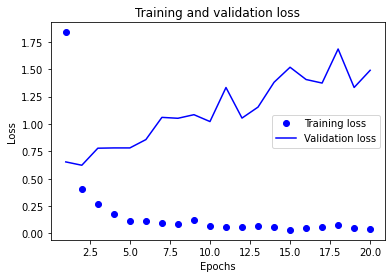

In [46]:
loss = vgg_model.history.history['loss']
val_loss = vgg_model.history.history['val_loss']
epochs = range(1, len(loss) + 1)
plt.plot(epochs, loss, 'bo', label='Training loss')
plt.plot(epochs, val_loss, 'b', label='Validation loss')
plt.title('Training and validation loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.savefig('VGG_Loss.png', dpi = 300)
plt.show()

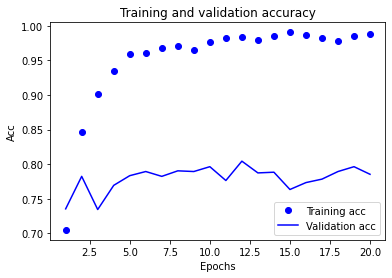

In [47]:
plt.clf()
acc = vgg_model.history.history['accuracy']
val_acc = vgg_model.history.history['val_accuracy']
plt.plot(epochs, acc, 'bo', label='Training acc')
plt.plot(epochs, val_acc, 'b', label='Validation acc')
plt.title('Training and validation accuracy')
plt.xlabel('Epochs')
plt.ylabel('Acc')
plt.legend()
plt.savefig('VGG_Acc.png', dpi = 300)
plt.show()

In [48]:
res_model = models.Sequential()
#res_model.add(layers.Dense(8192, activation='relu'))
#res_model.add(layers.Dense(4096, activation='relu'))
#res_model.add(layers.Dense(2048, activation='relu'))
res_model.add(layers.Dense(1024, activation='relu', input_shape = [100367]))
res_model.add(layers.Dense(512, activation='relu'))
res_model.add(layers.Dense(128, activation='relu'))
res_model.add(layers.Dense(4))

In [49]:
res_model.compile(optimizer='Adam',
              loss=tf.nn.softmax_cross_entropy_with_logits,
              metrics=['accuracy'])
res_model.fit(new_RES, new_y, epochs=20, validation_split=0.1)

Train on 9013 samples, validate on 1002 samples
Epoch 1/20
9013/9013 [==============================] - 10s 1ms/sample - loss: 1.7678 - accuracy: 0.7030 - val_loss: 0.6460 - val_accuracy: 0.7515
Epoch 2/20
9013/9013 [==============================] - 9s 1ms/sample - loss: 0.4018 - accuracy: 0.8527 - val_loss: 0.5984 - val_accuracy: 0.7605
Epoch 3/20
9013/9013 [==============================] - 9s 1ms/sample - loss: 0.2170 - accuracy: 0.9236 - val_loss: 0.7603 - val_accuracy: 0.7605
Epoch 4/20
9013/9013 [==============================] - 9s 1ms/sample - loss: 0.1631 - accuracy: 0.9436 - val_loss: 0.8885 - val_accuracy: 0.7665
Epoch 5/20
9013/9013 [==============================] - 9s 1ms/sample - loss: 0.1024 - accuracy: 0.9646 - val_loss: 0.8713 - val_accuracy: 0.7774
Epoch 6/20
9013/9013 [==============================] - 9s 1ms/sample - loss: 0.0530 - accuracy: 0.9834 - val_loss: 1.1835 - val_accuracy: 0.7764
Epoch 7/20
9013/9013 [==============================] - 9s 1ms/sample - los

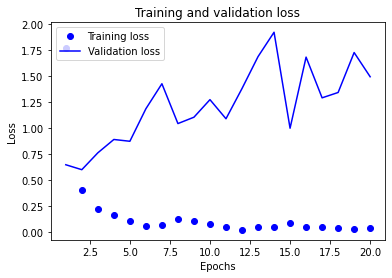

In [50]:
loss = res_model.history.history['loss']
val_loss = res_model.history.history['val_loss']
epochs = range(1, len(loss) + 1)
plt.plot(epochs, loss, 'bo', label='Training loss')
plt.plot(epochs, val_loss, 'b', label='Validation loss')
plt.title('Training and validation loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.savefig('RES_Loss.png', dpi = 300)
plt.show()

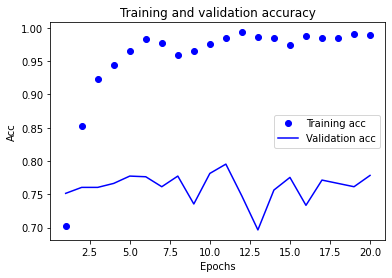

In [51]:
plt.clf()
acc = res_model.history.history['accuracy']
val_acc = res_model.history.history['val_accuracy']
plt.plot(epochs, acc, 'bo', label='Training acc')
plt.plot(epochs, val_acc, 'b', label='Validation acc')
plt.title('Training and validation accuracy')
plt.xlabel('Epochs')
plt.ylabel('Acc')
plt.legend()
plt.savefig('RES_Acc.png', dpi = 300)
plt.show()

In [54]:
df.groupby("risk")["localization"].value_counts()

risk  localization   
0.0   face                327
      lower extremity     283
      back                226
      upper extremity     139
      trunk               104
      chest                80
      abdomen              73
      scalp                36
      neck                 34
      unknown              23
      hand                 19
      ear                   6
      foot                  3
      genital               3
1.0   lower extremity    1479
      back               1427
      trunk              1241
      abdomen             860
      upper extremity     655
      foot                284
      chest               200
      unknown             196
      face                100
      neck                 81
      hand                 55
      genital              45
      scalp                45
      ear                  30
      acral                 7
2.0   face                113
      lower extremity      65
      upper extremity      62
      back        

In [55]:
iv3_model = models.Sequential()
#iv3_model.add(layers.Dense(8192, activation='relu'))
#iv3_model.add(layers.Dense(4096, activation='relu'))
#iv3_model.add(layers.Dense(2048, activation='relu'))
iv3_model.add(layers.Dense(1024, activation='relu', input_shape = [131087]))
iv3_model.add(layers.Dense(512, activation='relu'))
iv3_model.add(layers.Dense(128, activation='relu'))
iv3_model.add(layers.Dense(4))

In [57]:
iv3_model.compile(optimizer='Adam',
              loss=tf.nn.softmax_cross_entropy_with_logits,
              metrics=['accuracy'])
iv3_model.fit(new_IV3, new_y, epochs=20, validation_split=0.1)

Train on 9013 samples, validate on 1002 samples
Epoch 1/20
9013/9013 [==============================] - 12s 1ms/sample - loss: 0.1793 - accuracy: 0.9462 - val_loss: 1.0507 - val_accuracy: 0.7675
Epoch 2/20
9013/9013 [==============================] - 12s 1ms/sample - loss: 0.1072 - accuracy: 0.9644 - val_loss: 1.3267 - val_accuracy: 0.7545
Epoch 3/20
9013/9013 [==============================] - 12s 1ms/sample - loss: 0.1108 - accuracy: 0.9642 - val_loss: 0.8789 - val_accuracy: 0.7675
Epoch 4/20
9013/9013 [==============================] - 12s 1ms/sample - loss: 0.0883 - accuracy: 0.9697 - val_loss: 1.6794 - val_accuracy: 0.7395
Epoch 5/20
9013/9013 [==============================] - 12s 1ms/sample - loss: 0.0710 - accuracy: 0.9756 - val_loss: 1.1815 - val_accuracy: 0.7575
Epoch 6/20
9013/9013 [==============================] - 12s 1ms/sample - loss: 0.0448 - accuracy: 0.9846 - val_loss: 1.2368 - val_accuracy: 0.7625
Epoch 7/20
9013/9013 [==============================] - 12s 1ms/sample

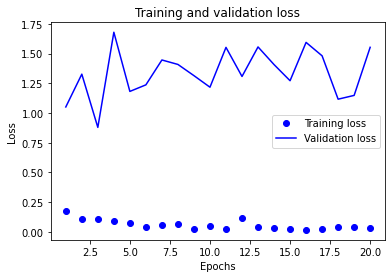

In [58]:
loss = iv3_model.history.history['loss']
val_loss = iv3_model.history.history['val_loss']
epochs = range(1, len(loss) + 1)
plt.plot(epochs, loss, 'bo', label='Training loss')
plt.plot(epochs, val_loss, 'b', label='Validation loss')
plt.title('Training and validation loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.savefig('IV3_Loss.png', dpi = 300)
plt.show()

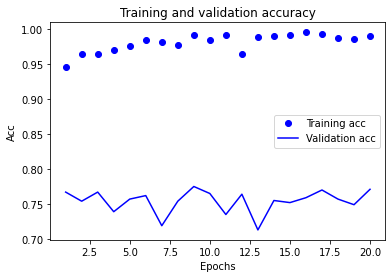

In [59]:
plt.clf()
acc = iv3_model.history.history['accuracy']
val_acc = iv3_model.history.history['val_accuracy']
plt.plot(epochs, acc, 'bo', label='Training acc')
plt.plot(epochs, val_acc, 'b', label='Validation acc')
plt.title('Training and validation accuracy')
plt.xlabel('Epochs')
plt.ylabel('Acc')
plt.legend()
plt.savefig('IV3_Acc.png', dpi = 300)
plt.show()

In [79]:
pickle_in = open("VGG_weight.pkl", "rb")
VGG_weight = pickle.load(pickle_in)

In [88]:
iv3_model

In [82]:
vgg_test = models.Sequential()
#vgg_model.add(layers.Dense(8192, activation='relu'))
#vgg_model.add(layers.Dense(4096, activation='relu'))
#vgg_model.add(layers.Dense(2048, activation='relu'))
vgg_test.add(layers.Dense(1024, activation='relu',input_shape = [25088]))
vgg_test.add(layers.Dense(512, activation='relu'))
vgg_test.add(layers.Dense(128, activation='relu'))
vgg_test.add(layers.Dense(4))

In [99]:
vgg_test.set_weights(VGG_weight)

In [102]:
img = image.load_img("ISIC_0024306.jpg", target_size= (224,224))
img = image.img_to_array(img)
img = np.expand_dims(img, axis=0)
img = tf.keras.applications.vgg16.preprocess_input(img)
preds = model.predict(img).reshape(25088)

In [114]:
preds.shape

(25088,)

In [113]:
preds.shape

(25088,)

In [115]:
vgg_test.predict(np.array([preds]))

array([[-13.825001 ,  -9.6455345,  71.92838  , -38.156006 ]],
      dtype=float32)